## TODO
1. Plot net load curve
1. Source for emissions
1. Add generation mix for CO2 cap
1. Plot opt capacity for weather years (change Co2 cap?)
1. Fix hydro CF

## Task A: optimize a region

In [77]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
import os
import sys
import contextlib
warnings.filterwarnings("ignore")

# Function to reduce console print of optimizer
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Import datasets for region and year of interest
country = "FIN"
year = 2015

demand_all = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True )
demand_all.index = demand_all.index.tz_localize(None)
demand = demand_all[country].loc[demand_all.index.year == year]

onshore_all = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore_all.index = onshore_all.index.tz_localize(None)
onshore_all = onshore_all[~((onshore_all.index.month == 2) & (onshore_all.index.day == 29))] # Remove leap day
onshore_2015 = onshore_all[country].loc[onshore_all.index.year == year]

solar_all = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar_all.index = solar_all.index.tz_localize(None)
solar_all = solar_all[~((solar_all.index.month == 2) & (solar_all.index.day == 29))] # Remove leap day
solar_2015 = solar_all[country].loc[solar_all.index.year == year]

heat_all = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat_all.index = heat_all.index.tz_localize(None)
heat = heat_all[country].loc[solar_2015.index.year == year]

# Import hydro data
hydro_all = pd.read_csv("hydro.csv", sep=";", index_col=0, parse_dates=True)
hydro_all = hydro_all["Hydro power production - real time data"]
hydro_all.index = hydro_all.index.tz_localize(None)
hydro_all = hydro_all.resample("H").mean()/3100 # Estimate capacity factor based on current installed capacity of 3.1 GW
hydro_all = hydro_all.fillna(method="ffill") # Fill NaN with previous value
hydro_all = hydro_all[~((hydro_all.index.month == 2) & (hydro_all.index.day == 29))] # Remove leap day
hydro_2015 = hydro_all.loc[hydro_all.index.year == year]

# Extend hydro data to cover the entire period of interest
start_target = pd.Timestamp('1979-01-01 00:00')
end_target = pd.Timestamp('2017-12-31 23:00')
num_repeats = 11
hydro_extended = pd.concat([hydro_all.copy() for _ in range(num_repeats)], axis=0)
hydro_extended.index = pd.date_range(start=start_target, periods=len(hydro_extended), freq='H')

# Remove leap day
hydro_extended = hydro_extended[~((hydro_extended.index.month == 2) & (hydro_extended.index.day == 29))] # Remove leap day
# Keep only data within the target range
hydro_extended = hydro_extended[(hydro_extended.index >= start_target) & (hydro_extended.index <= end_target)]

# Get snapshots for the year of interest
snapshots = demand.index


In [78]:
# Annuity function for converging capital costs to annualized costs
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

# Import costs from PyPSA technology data
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert cost units to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [79]:
# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots.values)

# Add electricity bus
network.add("Bus", "FIN_el")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "biomass CHP",
    "coal",
    "hydro",

]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red", "purple"]

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Define capacity factors for each carrier
CF = pd.DataFrame(1, index=snapshots, columns=carriers)
CF = CF.assign(onwind=onshore_2015.values, solar=solar_2015.values, hydro=hydro_2015.values )

# Add electricity load
network.add("Load", "el_load", bus="FIN_el", p_set=demand.values)

# Add generators
for carrier in carriers:
        network.add("Generator", carrier, bus="FIN_el", p_nom_extendable=True, 
                    p_max_pu      = CF[carrier].values,
                    marginal_cost = costs.at[carrier, "marginal_cost"], 
                    efficiency    = costs.at[carrier, "efficiency"], 
                    capital_cost  = costs.at[carrier, "capital_cost"], 
                    carrier       = carrier
        )

# Limit the capacity of hydro
network.generators.loc["hydro", "p_nom_max"] = 3100 # MW


# Optimize with reduced output
# Suppress the solver output by using the context manager
with suppress_stdout():
    network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 43.37it/s]
INFO:linopy.io: Writing time: 0.33s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-e_4ihtqb.lp
INFO:gurobipy:Reading time = 0.13 seconds
INFO:gurobipy:obj: 131408 rows, 61327 columns, 241259 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131408 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


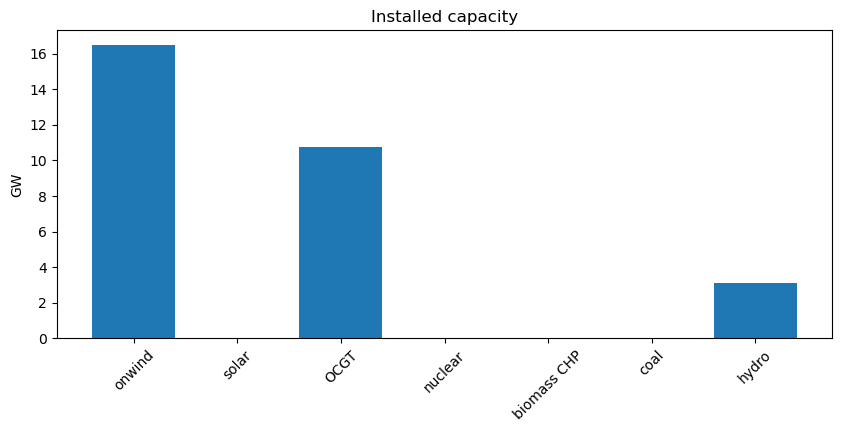

In [80]:
# Extract results
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

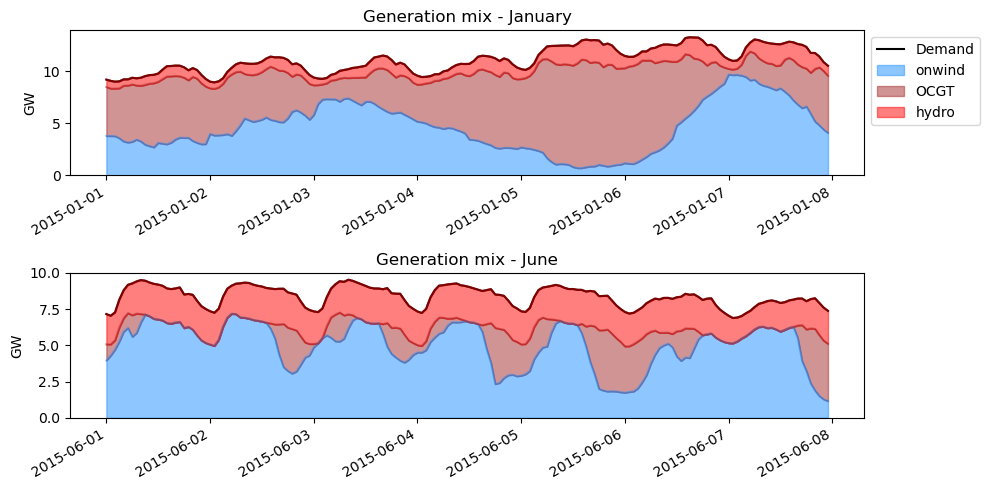

In [81]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-7"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-7"

demand_jan = demand.loc[start_date_jan:end_date_jan].div(1e3) # Convert to GW
generator_jan = gen_prod.loc[start_date_jan:end_date_jan,  (gen_prod != 0).any(axis=0)].div(1e3)

demand_jun = demand.loc[start_date_jun:end_date_jun, ].div(1e3)
generator_jun = gen_prod.loc[start_date_jun:end_date_jun, (gen_prod != 0).any(axis=0)].div(1e3)


fig, ax = plt.subplots(2, 1, figsize=(10,5))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January")
ax[0].set_ylabel("GW")
ax[0].set_xlabel("")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June")
ax[1].set_ylabel("GW")
ax[1].set_xlabel("")

plt.subplots_adjust(hspace=0.5, bottom=0.1, right=0.95, top=0.9)
plt.tight_layout()
plt.show()

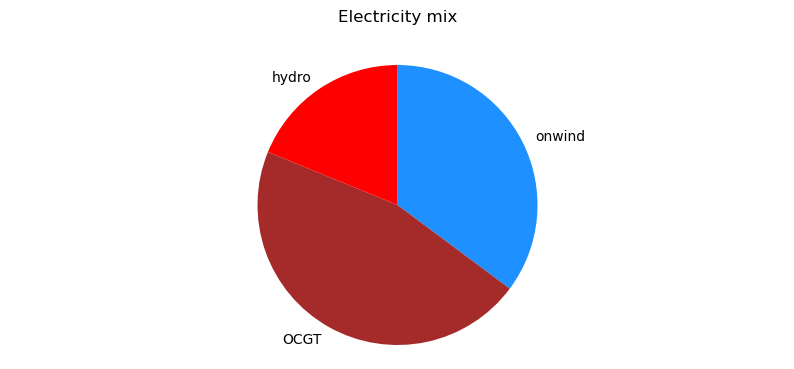

In [82]:
# Plot electricity mix
energy_production = network.generators_t.p
energy_sum = energy_production.sum(axis=0)
energy_sum = energy_sum[energy_sum != 0]

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
plt.pie(energy_sum.values, labels=energy_sum.index, colors=energy_sum.index.map(network.carriers.color), startangle=90, counterclock=False);
plt.axis('equal')
plt.title('Electricity mix', y=1.07)
plt.show()

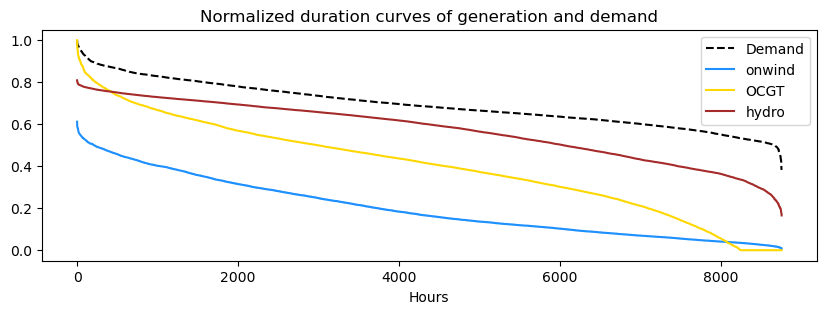

In [83]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(energy_sum.index):
    ax.plot((energy_production[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.title("Normalized duration curves of generation and demand")
plt.xlabel("Hours")
plt.show()

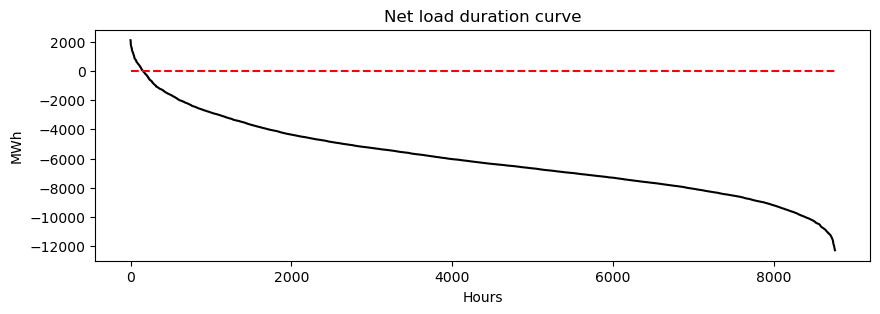

In [84]:
# Plot net load duration curve
fig, ax = plt.subplots(1, 1, figsize=(10,3))

net_load = (gen_cap * CF)["onwind"] - demand
net_load.sort_values(ascending=False).reset_index(drop=True).plot(color="black")
plt.title("Net load duration curve")
plt.xlabel("Hours")
plt.ylabel("MWh")
plt.hlines(0, 0, len(net_load), color="red", linestyle="--")
plt.show()

## B: CO2 limits

In [85]:
# Add a CO2 limit constraint, for now a dummy value
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=119E5, #11.9MtCO2
    type="primary_energy",
)

Index(['CO2Limit'], dtype='object')

In [86]:
# Prepare for sensitivity analysis
sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = {}

# Compute the total system cost (capital + operational) for the current network
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

# Define the CO2 limits for sensitivity analysis and run the optimization for each limit
co2Limits = [30, 25, 20, 15, 11.9, 8, 6.23, 3, 1.5, 0.5]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6 # MtCO2/a
    
    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

    
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt.copy()
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 41.84it/s]
INFO:linopy.io: Writing time: 0.37s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-ebove7vh.lp
INFO:gurobipy:Reading time = 0.14 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267539 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 5.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['F

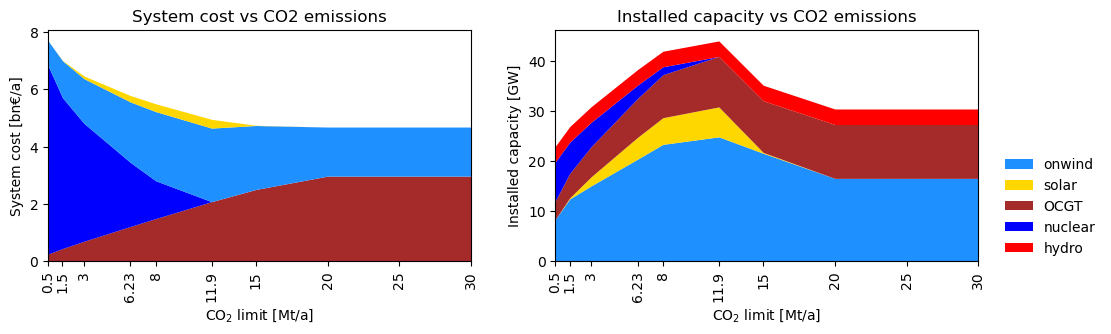

In [87]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3)  # GW
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a

# Include only technologies that are used in the network
sens_cost = sens_cost.loc[:, sens_cost.sum() != 0]
sens_cap = sens_cap.loc[:, sens_cap.sum() != 0]

fix, ax = plt.subplots(1,2, figsize=(12,3))
# Plot system cost vs CO2 emissions
sens_cost.plot.area(
    ax = ax[0],
    stacked=True, linewidth=0,
    color=sens_cost.columns.map(network.carriers.color),
    xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ limit [Mt/a]",
    ylabel="System cost [bn€/a]",
    title="System cost vs CO2 emissions",
)
ax[0].set_xticks(co2Limits, co2Limits, rotation=90)
ax[0].get_legend().remove()

sens_cap.plot.area(ax = ax[1], 
                  stacked = True, linewidth=0,
                  color = sens_cap.columns.map(network.carriers.color),
                  xlim=(min(co2Limits), max(co2Limits)),
                  xlabel=r"CO$_2$ limit [Mt/a]",
                  ylabel="Installed capacity [GW]",
                  title="Installed capacity vs CO2 emissions",
)

ax[1].set_xticks(co2Limits, co2Limits, rotation=90)
ax[1].legend(frameon=False, loc=(1.05, 0))
plt.show()

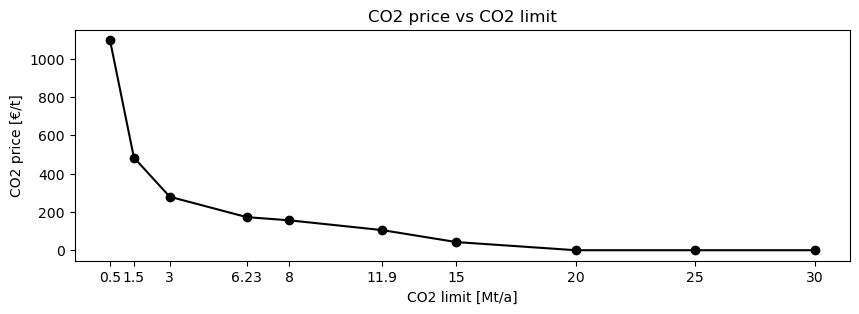

In [88]:
# Plot CO2 price vs CO2 limit
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(co2Limits, co2_price.values(), marker="o", color="black")
ax.set_xticks(co2Limits, co2Limits)
ax.set_xlabel("CO2 limit [Mt/a]")
ax.set_ylabel("CO2 price [€/t]")
ax.set_title("CO2 price vs CO2 limit")
plt.show()

## C: new weather

In [89]:
weather_years = np.arange(1979, 2018)

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}

# Fix CO2 limit
network.global_constraints.loc["CO2Limit", "constant"] = 3 * 1e6 # MtCO2/a

for year in weather_years:
    onshore = onshore_all.loc[onshore_all.index.year == year, country]
    solar = solar_all.loc[solar_all.index.year == year, country]
    hydro = hydro_extended.loc[hydro_extended.index.year == year]

    # Update model
    network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values,
                                       solar=solar.values,
                                       hydro=hydro.values)

    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})


    sensitivity_cost[year] = system_cost(network)
    sensitivity_capacity[year] = network.generators.p_nom_opt.copy()
    sensitivity_production[year] = network.generators_t.p.copy()

sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T.div(1e3) # GW

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 41.88it/s]
INFO:linopy.io: Writing time: 0.37s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-di388jf4.lp
INFO:gurobipy:Reading time = 0.13 seconds
INFO:gurobipy:obj: 131409 rows, 61327 columns, 267571 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131409 duals
Objective: 7.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['F

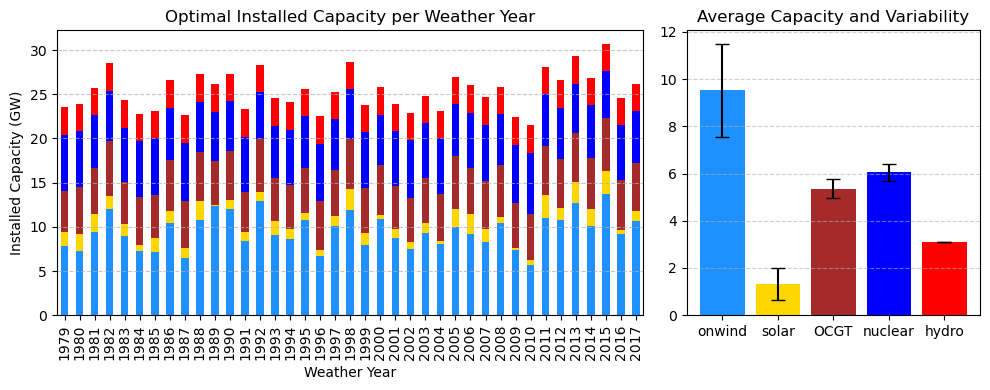

yearly generation statistics:
Generator     onwind      solar       OCGT    nuclear         hydro
count      39.000000  39.000000  39.000000  39.000000  3.900000e+01
mean        9.527525   1.319222   5.352720   6.043679  3.100000e+00
std         1.961350   0.667706   0.400101   0.372340  2.249473e-15
min         5.690694   0.121763   4.547755   5.320083  3.100000e+00
25%         8.046694   0.850582   5.075564   5.778609  3.100000e+00
50%         9.269656   1.189180   5.349983   6.027681  3.100000e+00
75%        10.798013   1.750321   5.640102   6.328151  3.100000e+00
max        13.750218   2.655085   6.265090   6.884970  3.100000e+00
Yearly cost statistics:
count    39.000000
mean      6.919692
std       0.132997
min       6.612531
25%       6.832839
50%       6.921942
75%       7.009839
max       7.221983
dtype: float64


In [90]:
color=sens_cost.columns.map(network.carriers.color)
# Clean sens_cap: remove columns with very small capacity
sens_cap_clean = sens_cap.loc[:, sens_cap.max() > 0.1]

# Only plot the carriers present in sens_cap
present_carriers = sens_cap_clean.columns

# Map the correct colors from network.carriers.color
plot_colors = present_carriers.map(network.carriers.color)

# Calculate average and standard deviation
mean_cap = sens_cap_clean.mean(axis=0)
std_cap = sens_cap_clean.std(axis=0)

fig, ax = plt.subplots(1,2, figsize=(10,4), gridspec_kw={'width_ratios': [2, 1]})

sens_cap_clean.plot(
    kind="bar",
    stacked=True,
    color=plot_colors,
    ax = ax[0])
ax[0].set_title("Optimal Installed Capacity per Weather Year")
ax[0].set_xlabel("Weather Year")
ax[0].set_ylabel("Installed Capacity (GW)")
# ax[0].legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].get_legend().remove()
ax[0].grid(axis="y", linestyle="--", alpha=0.7)


ax[1].bar(mean_cap.index, mean_cap.values, 
        yerr=[std_cap.values, std_cap.values], 
        capsize=5, 
        color=mean_cap.index.map(network.carriers.color))
# ax[1].set_ylabel("Installed Capacity (GW)")
ax[1].set_title("Average Capacity and Variability")
ax[1].grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("yearly generation statistics:")
print(sens_cap_clean.describe())

print("Yearly cost statistics:")
yearly_cost = sens_cost.sum(axis=1)
print(yearly_cost.describe())

In [91]:
sens_cap_clean

Generator,onwind,solar,OCGT,nuclear,hydro
1979,7.801233,1.605143,4.600599,6.408118,3.1
1980,7.306687,1.857276,5.331760,6.321144,3.1
1981,9.384837,2.097853,5.169508,5.998476,3.1
1982,11.974309,1.530655,6.265090,5.650689,3.1
1983,8.954248,1.346674,4.789277,6.111824,3.1
1984,7.284949,0.620616,5.431407,6.383930,3.1
1985,7.103141,1.617838,4.869787,6.438036,3.1
1986,10.385997,1.451775,5.705555,5.924957,3.1
1987,6.449236,1.180493,5.342768,6.552022,3.1
1988,10.815610,2.131807,5.533264,5.660717,3.1


## D: Add storage

In [92]:
# Reset basis year to 2015
year = 2015
network.global_constraints.loc["CO2Limit", "constant"] = co2 * 3e6 # MtCO2/a

onshore = onshore_all[country].loc[onshore_all.index.year == year]
solar = solar_all[country].loc[solar_all.index.year == year]
hydro = hydro_extended.loc[hydro_extended.index.year == year]

# Update model
network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values, hydro=hydro.values)

# Add storage bus
network.add("Carrier", "battery storage", co2_emissions=0, color="purple")
carriers.append("battery storage")

network.add(
    "StorageUnit",
    "battery storage",
    bus="FIN_el",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    overwrite=True,
)


# Optimize with reduced output
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 89.24it/s]
INFO:linopy.io: Writing time: 0.51s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-xl3gqe6k.lp
INFO:gurobipy:Reading time = 0.19 seconds
INFO:gurobipy:obj: 192730 rows, 87608 columns, 398940 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 192730 duals
Objective: 7.76e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageU

Text(0, 0.5, 'State of Charge (MWh)')

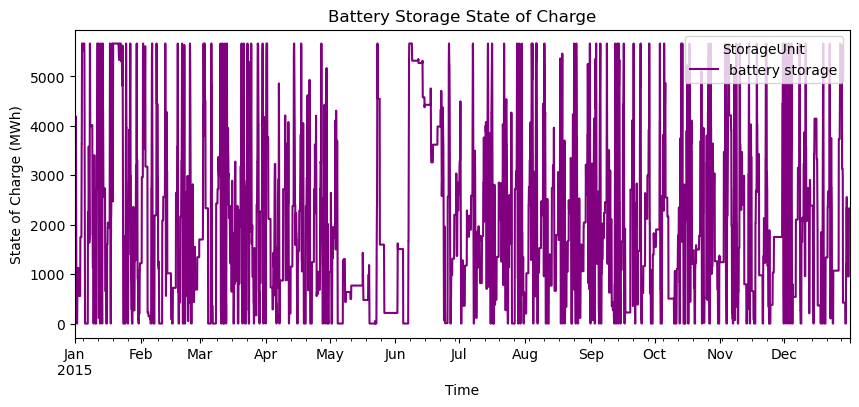

In [93]:
# plot battery storage
network.storage_units_t.state_of_charge.plot(figsize=(10, 4), color="purple")
plt.title("Battery Storage State of Charge")
plt.xlabel("Time")
plt.ylabel("State of Charge (MWh)")


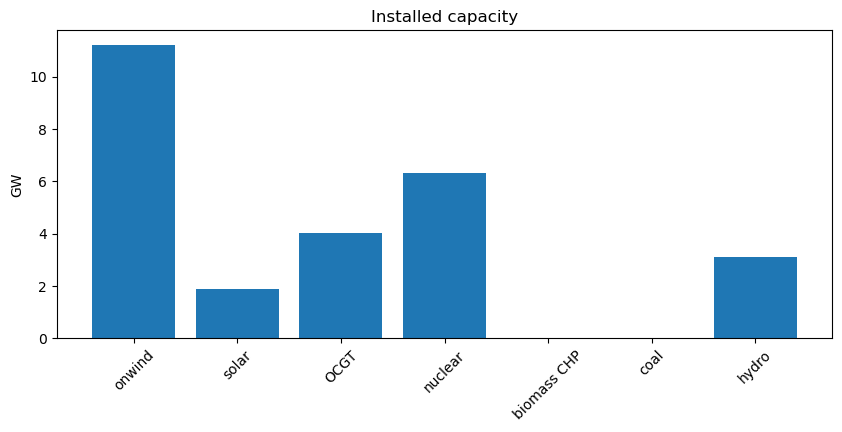

In [94]:
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.links.p_nom_opt], axis=0)
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

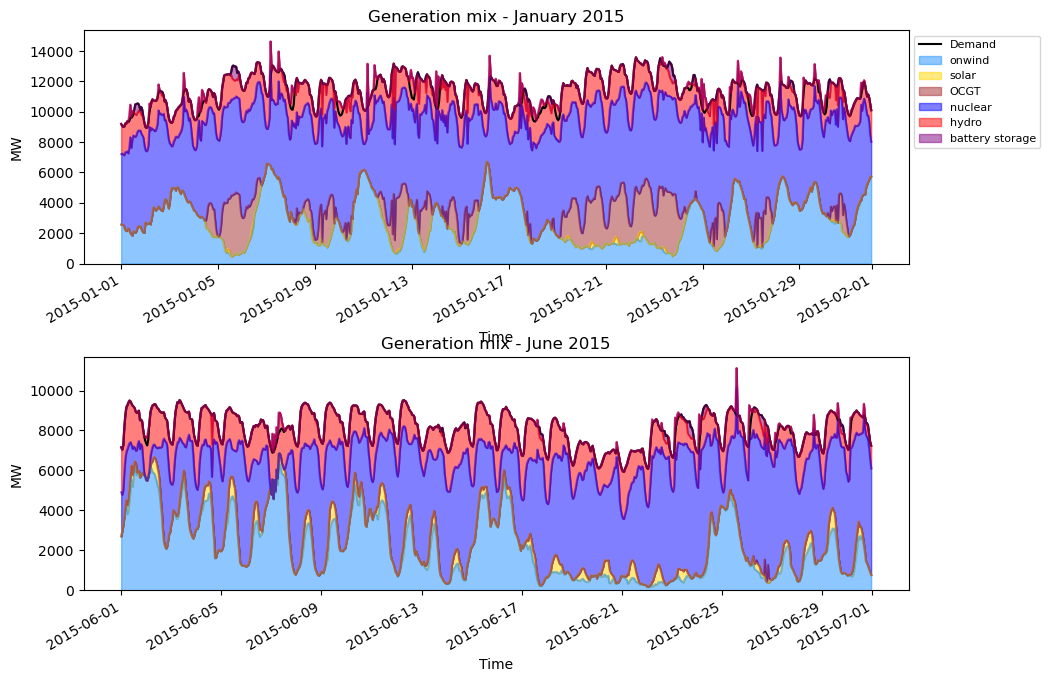

In [95]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-31"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-30"

demand_jan = demand.loc[start_date_jan:end_date_jan]
generator_jan = total_gen_prod.loc[start_date_jan:end_date_jan,  (total_gen_prod != 0).any(axis=0)]

demand_jun = demand.loc[start_date_jun:end_date_jun, ]
generator_jun = total_gen_prod.loc[start_date_jun:end_date_jun, (total_gen_prod != 0).any(axis=0)]


fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix - January 2015")
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Time")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_title("Generation mix - June 2015")
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Time")

plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

## E: Determine CO2 price for CO2 target

In [96]:
# Set CO2 limit to 0 and optimize again
network.global_constraints.loc["CO2Limit", "constant"] = 6 * 1E6 # MtCO2/a

# Optimize model
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

# Extract CO2 price
co2_price = -network.global_constraints.mu['CO2Limit']

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 85.87it/s]
INFO:linopy.io: Writing time: 0.52s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-rgbt0dmg.lp
INFO:gurobipy:Reading time = 0.19 seconds
INFO:gurobipy:obj: 192730 rows, 87608 columns, 398940 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 192730 duals
Objective: 6.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageU

CO2 price: 169.6599343321103 €/tCO2


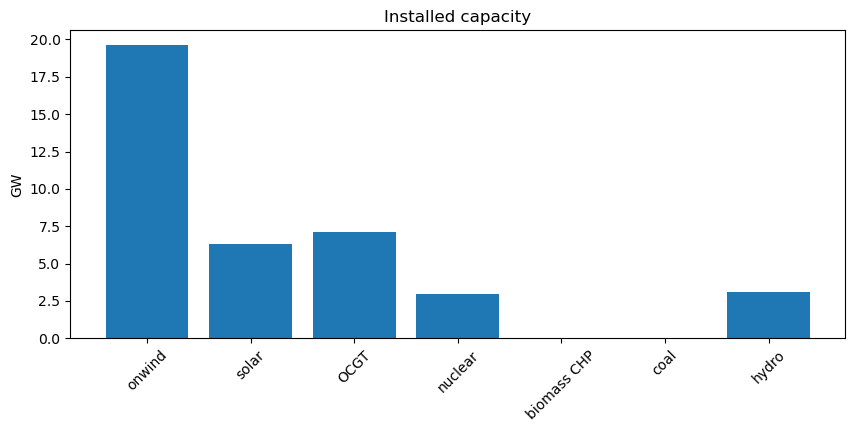

In [97]:

print(f"CO2 price: {co2_price} €/tCO2")
# Extract results
gen_cap = pd.concat([network.generators.p_nom_opt, network.links.p_nom_opt], axis=0)
gen_prod = network.generators_t.p
total_gen_prod = pd.concat([gen_prod, network.storage_units_t.p_dispatch], axis=1)

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index, rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

## F: Connect with neighbours

In [98]:
### Connect with estonia and sweden ###
network = pypsa.Network()
network.set_snapshots(snapshots.values)
countries = ["FIN", "EST", "SWE"]
coordinates = {
    "FIN": (64, 26),
    "EST": (59, 26),
    "SWE": (62, 15),
}

# Add a CO2 limit constraint
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=10E6, #MtCO2
    type="primary_energy",
)

# Add carriers to the network with CO2 emissions and colors
for i, carrier in enumerate(carriers):
    network.add("Carrier", carrier, co2_emissions=costs.at[carrier, "CO2 intensity"], color=colors[i])

# Add the new countries to the network
for country in countries:
    network.add("Bus", f"{country}_el", y = coordinates[country][0], x = coordinates[country][1], carrier = "AC")
    network.add("Bus", f"{country}_storage", carrier="battery storage", y = coordinates[country][0], x = coordinates[country][1])


    CF = pd.DataFrame(1, index=snapshots, columns=carriers)
    CF = CF.assign(onwind=onshore_all.loc[onshore_all.index.year == year, country].values,
                   solar=solar_all.loc[solar_all.index.year == year, country].values, 
                   hydro=hydro_2015.loc[hydro_2015.index.year == year].values )
    

    for carrier in carriers:
        if carrier != "battery storage":
            network.add("Generator", f"{carrier}_{country}", bus=f"{country}_el", p_nom_extendable=True,
                        p_max_pu=CF[carrier].values,
                        marginal_cost=costs.at[carrier, "marginal_cost"],
                        efficiency=costs.at[carrier, "efficiency"],
                        capital_cost=costs.at[carrier, "capital_cost"],
                        carrier=carrier
            )

    # Add electricity load
    network.add("Load", f"el_load_{country}", bus=f"{country}_el", p_set=demand_all.loc[demand.index.year == year, country].values)

    network.add(
    "StorageUnit",
    f"{country}_battery storage",
    bus=f"{country}_el",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
    overwrite=True,
    )

# Limit hydro capacity for each country corresponding to the installed capacity in 2015
network.generators.loc["hydro_EST", "p_nom_max"] = 0
network.generators.loc["hydro_FIN", "p_nom_max"] = 3100 # MW
network.generators.loc["hydro_SWE", "p_nom_max"] = 16_301 # MW

# Add interconnectors between countries
network.add("Link", "FIN-EST", bus0 = "FIN_el", bus1 = "EST_el", p_nom = 1e3, efficiency=0.95, p_max_pu=1, p_min_pu=-1, carrier = "AC")
network.add("Link", "FIN-SWE", bus0 = "FIN_el", bus1 = "SWE_el", p_nom = 2.4e3, efficiency=0.95, p_max_pu=1, p_min_pu=-1, carrier = "AC")

Index(['FIN-SWE'], dtype='object')

In [99]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN_el', 'EST_el', 'SWE_el'], dtype='object', name='Bus')
Index(['FIN-EST', 'FIN-SWE'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 33.00it/s]
INFO:linopy.io: Writing time: 1.61s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-l8eg0cz5.lp
INFO:gurobipy:Reading time = 0.62 seconds
INFO:gurobipy:obj: 613228 rows, 280344 columns, 1266563 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 280344 primals, 613228 duals
Objective: 1.49e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Genera

In [100]:
network.links.p_nom_opt

Link
FIN-EST    1000.0
FIN-SWE    2400.0
Name: p_nom_opt, dtype: float64

In [ ]:
# total capacity
network.generators.p_nom_opt.groupby([network.generators.bus, network.generators.carrier]).sum().div(1e3).round(1) #GW

bus     carrier    
EST_el  OCGT            1.1
        biomass CHP     0.0
        coal            0.0
        hydro           0.0
        nuclear         0.0
        onwind          4.3
        solar           2.8
FIN_el  OCGT            4.0
        biomass CHP     0.0
        coal            0.0
        hydro           3.1
        nuclear         2.6
        onwind         22.8
        solar           0.0
SWE_el  OCGT           11.9
        biomass CHP     0.0
        coal            0.0
        hydro          16.3
        nuclear         0.3
        onwind         29.5
        solar           6.3
Name: p_nom_opt, dtype: float64

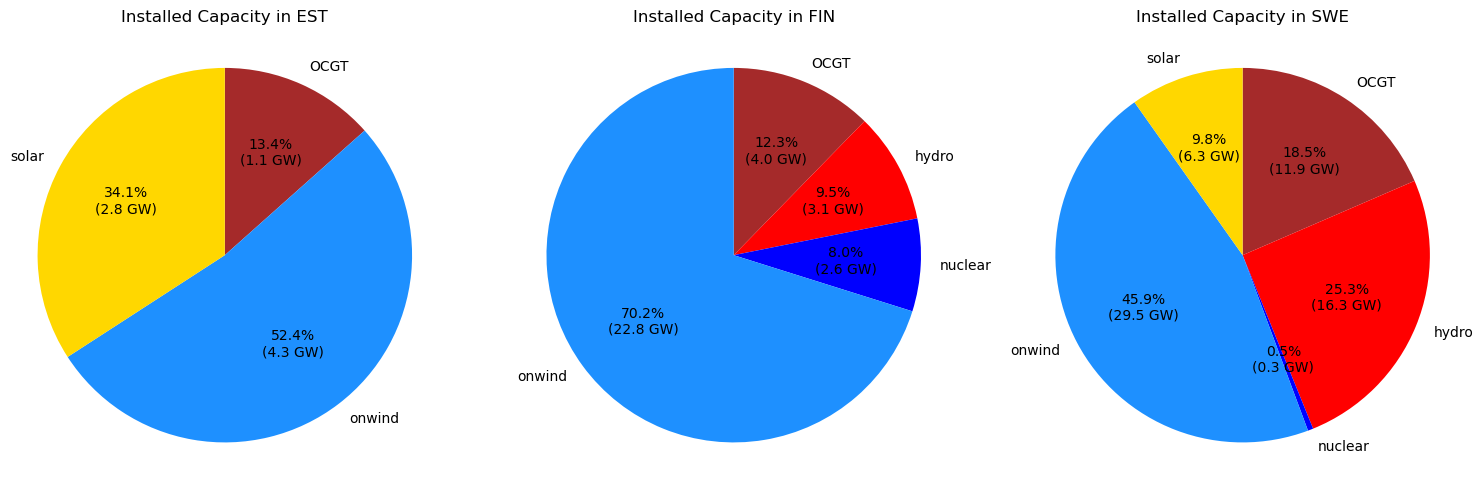

In [129]:

# Group installed capacities by bus and carrier
capacity_data = network.generators.p_nom_opt.groupby(
    [network.generators.bus, network.generators.carrier]
).sum().div(1e3).round(1)  # in GW

# Extract unique country codes
countries = sorted({bus.split("_")[0] for bus in capacity_data.index.get_level_values(0)})

# Plot pie charts
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

for i, country in enumerate(countries):
    # Filter data for current country
    country_data = capacity_data.loc[capacity_data.index.get_level_values(0) == f"{country}_el"]
    
    # Filter out zero-capacity entries
    filtered = country_data[country_data > 0]
    
    labels = filtered.index.get_level_values(1)  # technology names
    values = filtered.values
    colors_used = [network.carriers.at[tech, "color"] for tech in labels]
    
    axs[i].pie(
        values,
        labels=labels,
        colors=colors_used,
        startangle=90,
        counterclock=False,
        autopct=lambda pct: f"{pct:.1f}%\n({(pct / 100) * sum(values):.1f} GW)"
    )
    axs[i].axis("equal")
    axs[i].set_title(f"Installed Capacity in {country}")

plt.tight_layout()
plt.show()

In [132]:
# total generation
network.generators_t.p.sum(axis=0).groupby([network.generators.bus, network.generators.carrier]).sum().div(1e6).round(1) #GWh

bus     carrier    
EST_el  OCGT            2.5
        biomass CHP     0.0
        coal            0.0
        hydro           0.0
        nuclear         0.0
        onwind          7.3
        solar           2.4
FIN_el  OCGT            2.1
        biomass CHP     0.0
        coal            0.0
        hydro          15.5
        nuclear        13.1
        onwind         32.8
        solar           0.0
SWE_el  OCGT           16.1
        biomass CHP     0.0
        coal            0.0
        hydro          81.6
        nuclear         1.4
        onwind         45.6
        solar           5.1
dtype: float64

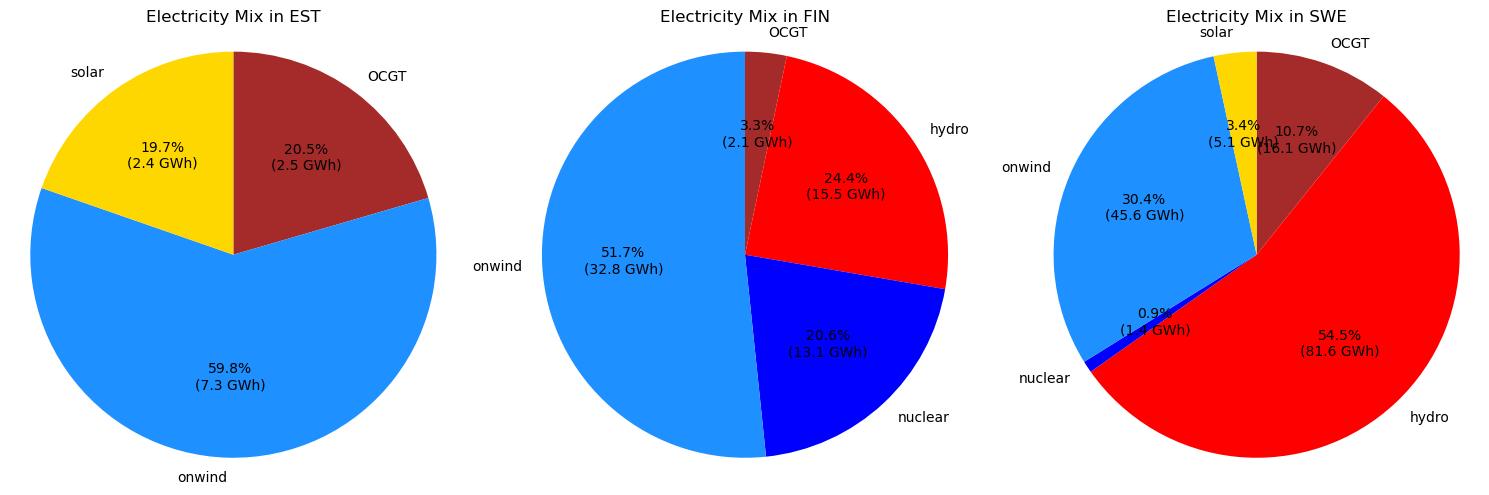

In [134]:
# Group generation by bus and carrier
generation_data = network.generators_t.p.sum(axis=0).groupby(
    [network.generators.bus, network.generators.carrier]
).sum().div(1e6).round(1)  # in GWh

# Extract country names
countries = sorted({bus.split("_")[0] for bus in generation_data.index.get_level_values(0)})

# Plot pie charts
fig, axs = plt.subplots(1, len(countries), figsize=(5 * len(countries), 5))

for i, country in enumerate(countries):
    # Filter generation data for this country
    country_data = generation_data.loc[generation_data.index.get_level_values(0) == f"{country}_el"]
    
    # Filter out zero-generation entries
    filtered = country_data[country_data > 0]
    
    labels = filtered.index.get_level_values(1)  # technology names
    values = filtered.values
    colors_used = [network.carriers.at[tech, "color"] for tech in labels]
    
    axs[i].pie(
        values,
        labels=labels,
        colors=colors_used,
        startangle=90,
        counterclock=False,
        autopct=lambda pct: f"{pct:.1f}%\n({(pct / 100) * sum(values):.1f} GWh)"
    )
    axs[i].axis("equal")
    axs[i].set_title(f"Electricity Mix in {country}")

plt.tight_layout()
plt.show()

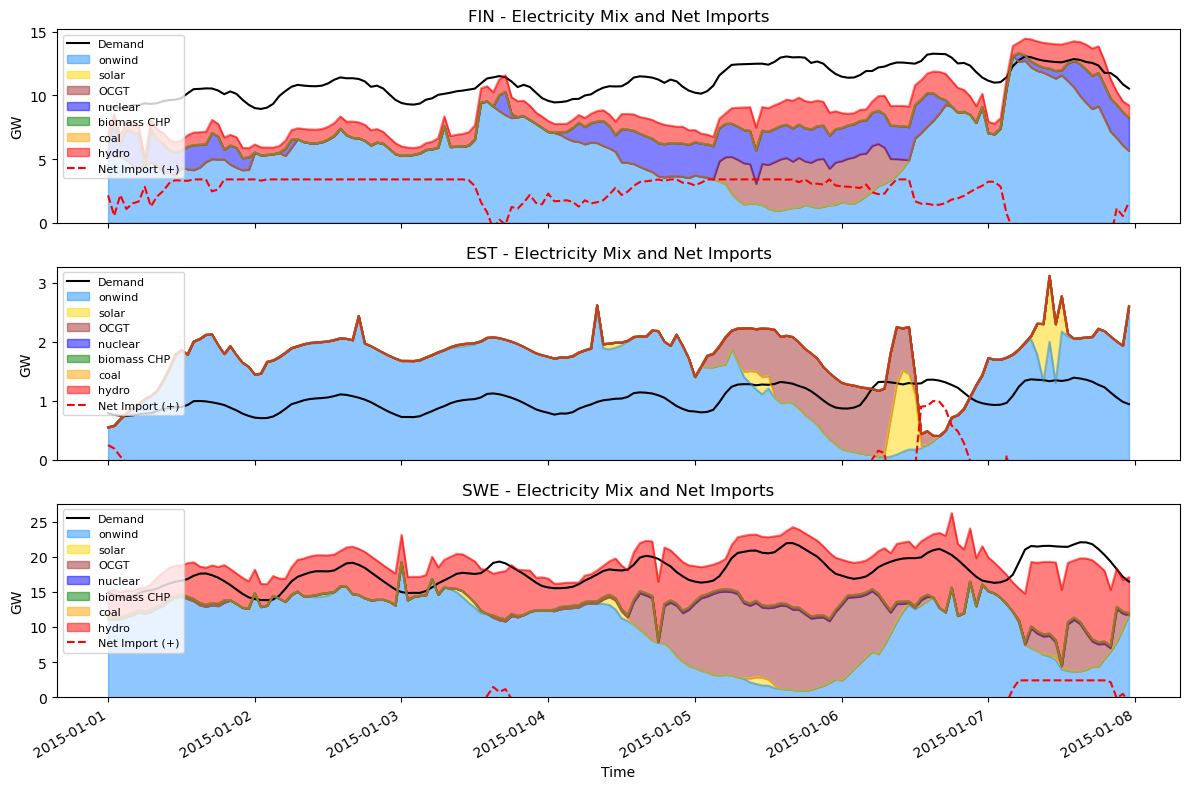

In [135]:

# Define the week
start_date = "2015-01-01"
end_date = "2015-01-07"
countries = ["FIN", "EST", "SWE"]

# Prepare the figure
fig, axs = plt.subplots(len(countries), 1, figsize=(12, 8), sharex=True)

for i, country in enumerate(countries):
    # Get generation for the country
    gen_cols = [col for col in network.generators_t.p.columns if col.endswith(f"_{country}")]
    generation = network.generators_t.p[gen_cols].loc[start_date:end_date].div(1e3)  # GW
    generation.columns = [col.split("_")[0] for col in gen_cols]  # simplify labels

    # Get demand
    demand_col = f"el_load_{country}"
    demand = network.loads_t.p_set[demand_col].loc[start_date:end_date].div(1e3)  # GW

    # Get net imports: sum of incoming/outgoing flows
    link_flows = network.links_t.p0.loc[start_date:end_date, :]
    net_import = 0
    for link in network.links.index:
        if link.endswith(f"-{country}"):
            net_import += link_flows[link]  # country is bus1 (importing)
        elif link.startswith(f"{country}-"):
            net_import -= link_flows[link]  # country is bus0 (exporting)
    net_import = net_import.div(1e3)  # GW

    # Plot demand line
    axs[i].plot(demand.index, demand.values, color="black", label="Demand")

    # Plot generation stack
    generation.plot.area(ax=axs[i], alpha=0.5, stacked=True,
                         color=[network.carriers.color.get(carrier, "gray") for carrier in generation.columns],
                         legend=False)

    # Plot net import/export line
    axs[i].plot(net_import.index, net_import.values, color="red", linestyle="--", label="Net Import (+)")

    # Labels and title
    axs[i].set_title(f"{country} - Electricity Mix and Net Imports")
    axs[i].set_ylabel("GW")
    axs[i].legend(loc="upper left", fontsize=8)

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

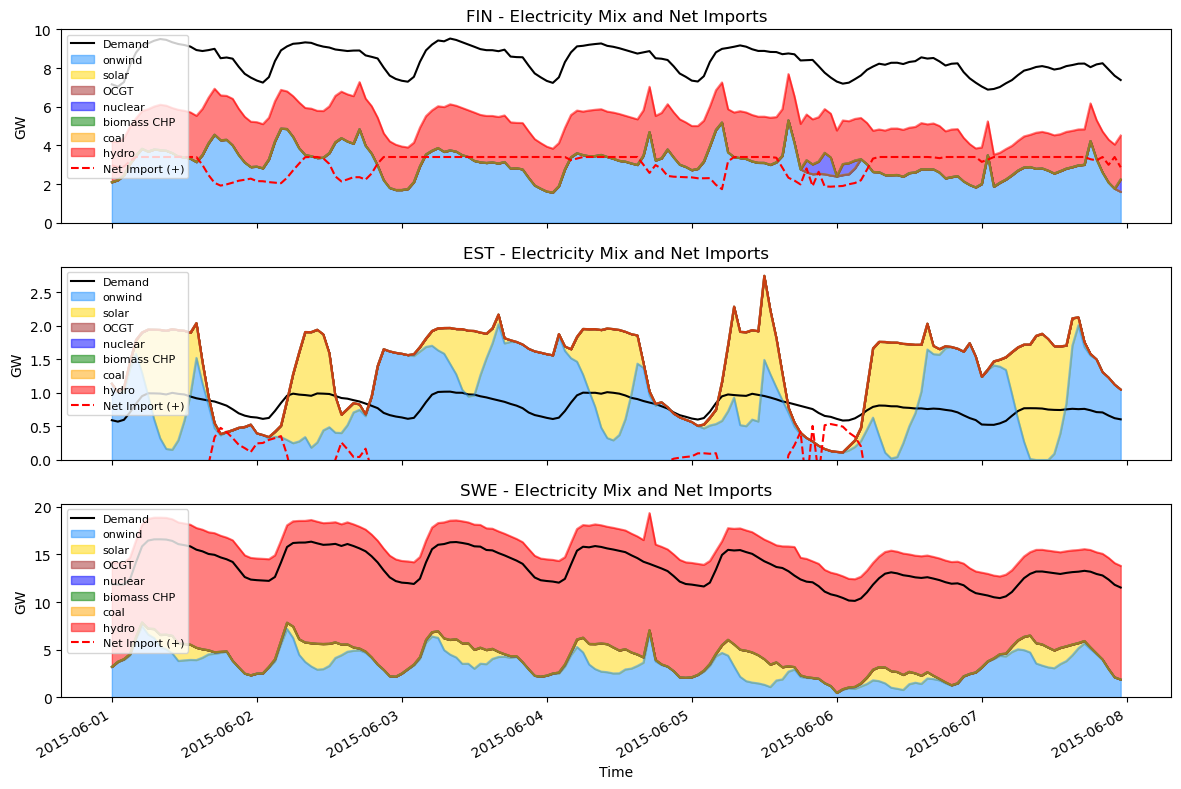

In [136]:

# Define the week
start_date = "2015-06-01"
end_date = "2015-06-07"
countries = ["FIN", "EST", "SWE"]

# Prepare the figure
fig, axs = plt.subplots(len(countries), 1, figsize=(12, 8), sharex=True)

for i, country in enumerate(countries):
    # Get generation for the country
    gen_cols = [col for col in network.generators_t.p.columns if col.endswith(f"_{country}")]
    generation = network.generators_t.p[gen_cols].loc[start_date:end_date].div(1e3)  # GW
    generation.columns = [col.split("_")[0] for col in gen_cols]  # simplify labels

    # Get demand
    demand_col = f"el_load_{country}"
    demand = network.loads_t.p_set[demand_col].loc[start_date:end_date].div(1e3)  # GW

    # Get net imports: sum of incoming/outgoing flows
    link_flows = network.links_t.p0.loc[start_date:end_date, :]
    net_import = 0
    for link in network.links.index:
        if link.endswith(f"-{country}"):
            net_import += link_flows[link]  # country is bus1 (importing)
        elif link.startswith(f"{country}-"):
            net_import -= link_flows[link]  # country is bus0 (exporting)
    net_import = net_import.div(1e3)  # GW

    # Plot demand line
    axs[i].plot(demand.index, demand.values, color="black", label="Demand")

    # Plot generation stack
    generation.plot.area(ax=axs[i], alpha=0.5, stacked=True,
                         color=[network.carriers.color.get(carrier, "gray") for carrier in generation.columns],
                         legend=False)

    # Plot net import/export line
    axs[i].plot(net_import.index, net_import.values, color="red", linestyle="--", label="Net Import (+)")

    # Labels and title
    axs[i].set_title(f"{country} - Electricity Mix and Net Imports")
    axs[i].set_ylabel("GW")
    axs[i].legend(loc="upper left", fontsize=8)

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

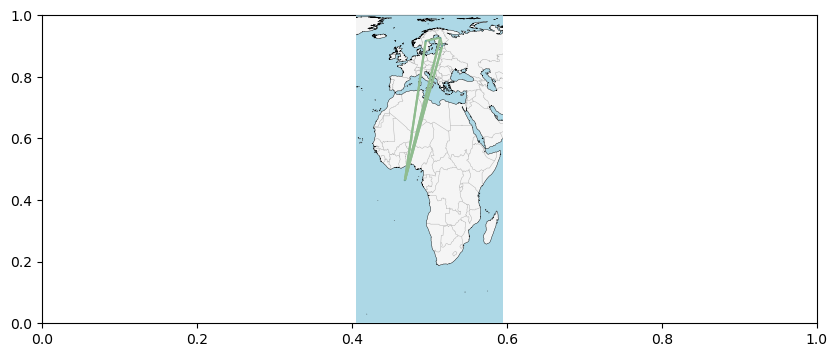

In [ ]:
# import cartopy.crs as ccrs

# fig, ax = plt.subplots(figsize=(10,4))
# network.plot(bus_sizes = 1/5, margin = 1, projection=ccrs.EqualEarth(),
#     color_geomap=True,
#     line_colors=network.lines_t.p0.mean().abs(),)
# plt.show()

In [59]:
# network.generators.p_nom_opt.plot.bar()

In [60]:
# gen = network.generators.assign(g=network.generators_t.p.sum()).groupby(["bus", "carrier"]).g.sum()
# gen_unstacked = gen.unstack()
# gen_unstacked.div(1E3).plot.bar()
# plt.ylabel("GWh")
# plt.show()

## G: Add sector coupling

In [61]:
# Import temperature data
temp_est = pd.read_excel("Estland_temp.xlsx")
temp_est.index = pd.to_datetime(temp_est['Päev'].astype(str) + '-' + 
                                temp_est['Kuu'].astype(str) + '-' + 
                                temp_est['Aasta'].astype(str) + " " +
                                temp_est["Kell (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S')
temp_est = temp_est["Õhutemperatuur °C"]

temp_swe = pd.read_csv("Sverige_temp.csv")
temp_swe.index = pd.to_datetime(temp_swe['Day'].astype(str) + '-' + 
                                temp_swe['Month'].astype(str) + '-' + 
                                temp_swe['Year'].astype(str) + " " +
                                temp_swe["Time [UTC]"].astype(str),
                                format='%d-%m-%Y %H:%M')
temp_swe = temp_swe["Average temperature [°C]"]

temp_fin = pd.read_csv("Finland_temp.csv", sep=";")
temp_fin.index = pd.to_datetime(temp_fin['Datum'].astype(str) + " " +
                                temp_fin["Tid (UTC)"].astype(str),
                                format='%d-%m-%Y %H:%M:%S') 
temp_fin = temp_fin["Lufttemperatur"]

temperature_df = pd.concat(
    [temp_est.rename("EST"), temp_fin.rename("FIN"), temp_swe.rename("SWE")], 
    axis=1
)

temperature_df = temperature_df.loc[(temperature_df.index.year >= 2012) & (temperature_df.index.year < 2018)]

In [62]:
T_sink = 55 # temperature of the heat sink

def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    cop = (6.81 - 0.121 * delta_t + 0.00063 * delta_t**2)
    cop = cop.fillna(method="ffill")
    return cop.values

network.add("Bus", "gas", carrier="OCGT") # Dummy gas bus
network.add("Store", "gas", e_initial=1E9, e_nom=1E9, bus="gas", carrier = "OCGT") 
network.add("Carrier","heat")


for country in countries:
    network.add("Bus", f"{country}_heat", y = coordinates[country][0], x = coordinates[country][1], carrier="heat")
    network.add("Load", f"heat_load_{country}", bus=f"{country}_heat", p_set=heat_all.loc[:,country].values, carrier = "heat")
    
    network.add(
        "Link",
        f"gas boiler_{country}",
        bus0="gas",
        bus1=f"{country}_heat",
        capital_cost=costs.at["gas boiler steam", "capital_cost"],  # €/MW/a
        marginal_cost=costs.at["gas boiler steam", "marginal_cost"],  # €/MWh
        p_nom_extendable=True,
        efficiency=costs.at["gas boiler steam", "efficiency"],
        carrier = "OCGT"
    )

    # Add heat pump
    temp = temperature_df.loc[temperature_df.index.year == year,f"{country}"] # temperature_df.index.year == year,

    network.add(
        "Link",
        f"heat pump_{country}",
        bus0=f"{country}_el",
        bus1=f"{country}_heat",
        efficiency=cop(temp),
        p_nom_extendable=True,
        capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],  # €/MWe/a
        marginal_cost=costs.at["central air-sourced heat pump", "marginal_cost"],  # €/MWh
        carrier = "heat"
    )


    network.add("Link", f"central gas CHP_{country}",
                bus0="gas",
                bus1=f"{country}_el",
                bus2=f"{country}_heat",
                efficiency=costs.loc["central gas CHP", "efficiency"],
                efficiency2=costs.loc["central gas CHP", "efficiency"],
                p_nom_extendable=True,
                marginal_cost=costs.loc["central gas CHP", "marginal_cost"], # €/MWh
                capital_cost=costs.at["central gas CHP", "capital_cost"],  # €/MWe/a
                carrier = "OCGT"
    )

    # Add heat storage
    network.add("StorageUnit", f"{country}_PTES",
                bus=f"{country}_heat",
                carrier="heat",
                capital_cost = 350, # €/MWh
                efficiency_store=0.8,
                standing_loss = 0.0002,
                efficiency_dispatch=1,
                p_nom_extendable=True,
                cyclic_state_of_charge=True,
    )

In [63]:
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN_el', 'EST_el', 'SWE_el'], dtype='object', name='Bus')
Index(['FIN-EST', 'FIN-SWE'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 10/10 [00:00<00:00, 28.39it/s]
INFO:linopy.io: Writing time: 2.69s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-jwqd2g1n.lp
INFO:gurobipy:Reading time = 1.08 seconds
INFO:gurobipy:obj: 1016200 rows, 455556 columns, 2133815 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 455556 primals, 1016200 duals
Objective: 2.16e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Ge

<Axes: ylabel='Link'>

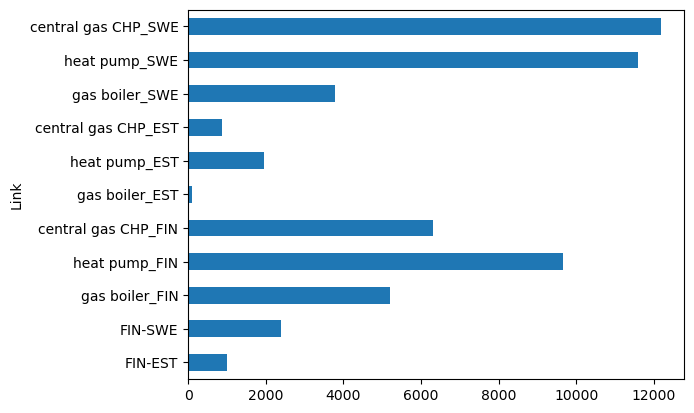

In [64]:
network.links.p_nom_opt.plot.barh()

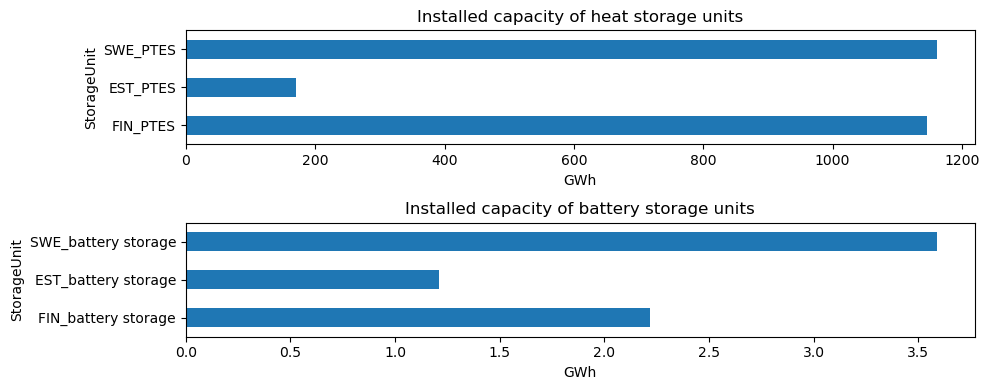

In [66]:
# Plot the installed capacity of the storage units
fig, ax = plt.subplots(2, 1, figsize=(10,4))
network.storage_units.loc[["FIN_PTES", "EST_PTES", "SWE_PTES"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[0])
ax[0].set_title("Installed capacity of heat storage units")
ax[0].set_xlabel("GWh")

network.storage_units.loc[["FIN_battery storage", "EST_battery storage", "SWE_battery storage"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[1])
ax[1].set_title("Installed capacity of battery storage units")
ax[1].set_xlabel("GWh")

plt.tight_layout()
plt.show()

<Axes: ylabel='Generator'>

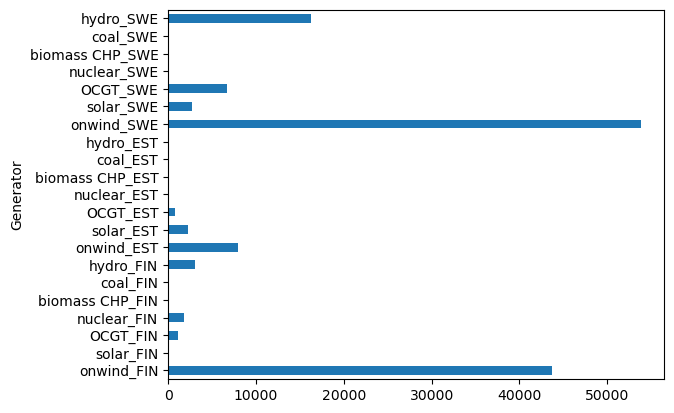

In [67]:
network.generators.p_nom_opt.plot.barh()

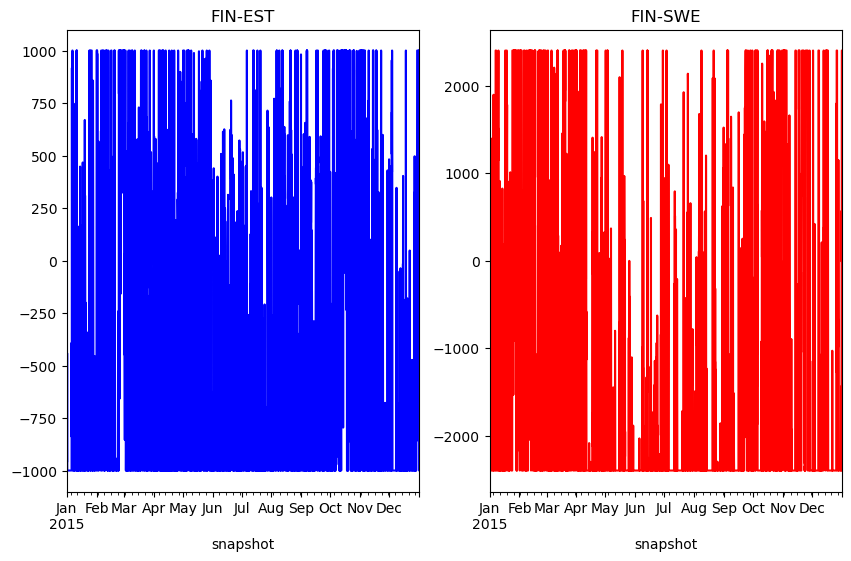

In [68]:
fix, ax = plt.subplots(1,2, figsize=(10, 6))

# Plot transmission between countries
network.links_t.p0.loc[:,"FIN-EST"].plot(ax=ax[0], color="blue", label="FIN-EST", title="FIN-EST")
network.links_t.p0.loc[:,"FIN-SWE"].plot(ax=ax[1], color="red", label="FIN-SWE", title="FIN-SWE")
plt.show()


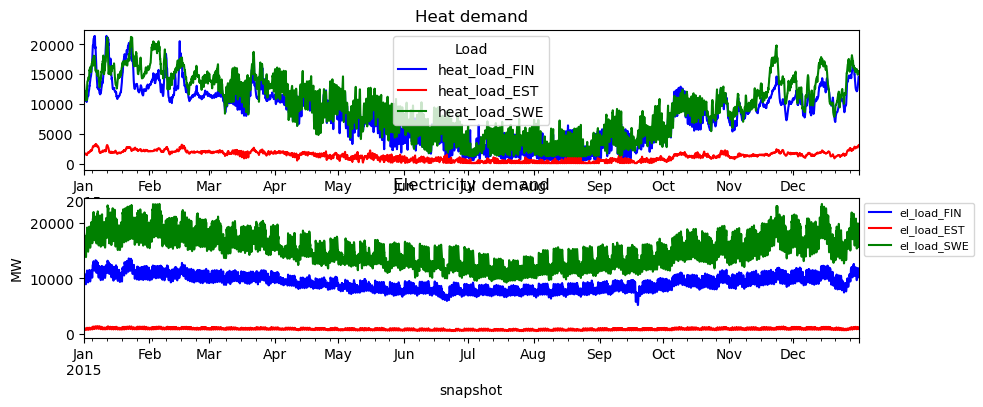

In [69]:
# print heat and electricity demand
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

network.loads_t.p_set.loc[:,["heat_load_FIN", "heat_load_EST", "heat_load_SWE"]].plot(title="Heat demand", figsize=(10, 4), ax=ax[0], color = ["blue", "red", "green"])
plt.ylabel("MW")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

network.loads_t.p_set.loc[:,["el_load_FIN", "el_load_EST", "el_load_SWE"]].plot(title="Electricity demand", figsize=(10, 4), ax=ax[1], color = ["blue", "red", "green"])
plt.ylabel("MW")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

plt.show()

## H: Explore new topic

In [70]:
# Impose a cap on onshore wind 
network.generators.loc["onwind_FIN", "p_nom_max"] = 21e3 # MW
network.generators.loc["onwind_EST", "p_nom_max"] = 2.3e3 # MW
network.generators.loc["onwind_SWE", "p_nom_max"] = 30e3 # MW

# Optimize
with suppress_stdout():
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

Index(['FIN_el', 'EST_el', 'SWE_el'], dtype='object', name='Bus')
Index(['FIN-EST', 'FIN-SWE'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 10/10 [00:00<00:00, 28.72it/s]
INFO:linopy.io: Writing time: 2.65s
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12
INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-9lx8b_47.lp
INFO:gurobipy:Reading time = 1.06 seconds
INFO:gurobipy:obj: 1016203 rows, 455556 columns, 2133818 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 455556 primals, 1016203 duals
Objective: 2.33e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Ge

<Axes: ylabel='Generator'>

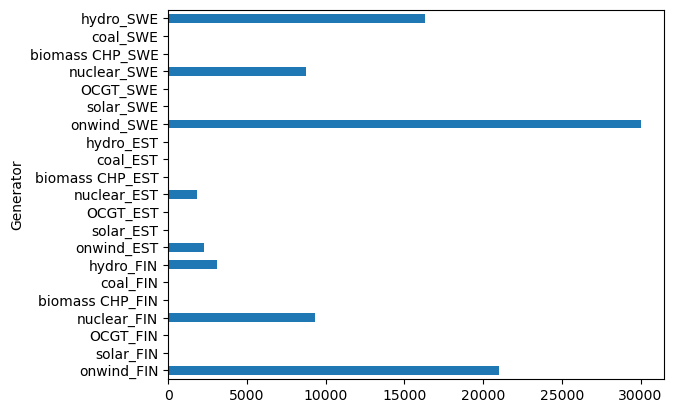

In [ ]:
network.generators.p_nom_opt.plot.barh()

<Axes: ylabel='Link'>

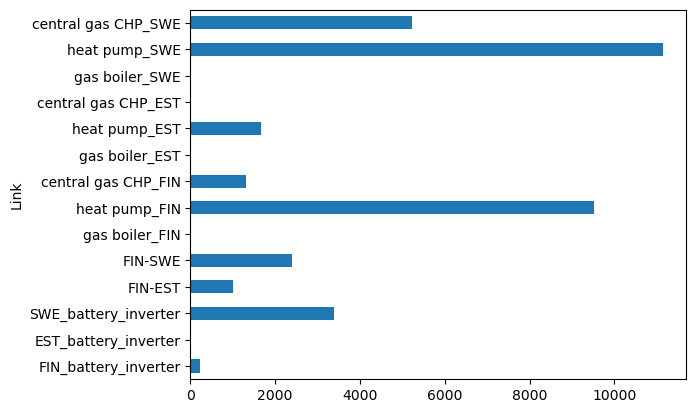

In [ ]:
network.links.p_nom_opt.plot.barh()

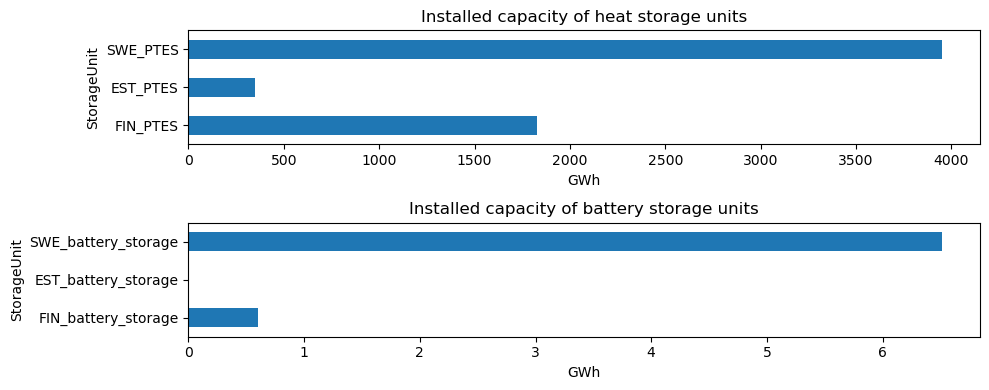

In [ ]:
# Plot the installed capacity of the storage units
fig, ax = plt.subplots(2, 1, figsize=(10,4))
network.storage_units.loc[["FIN_PTES", "EST_PTES", "SWE_PTES"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[0])
ax[0].set_title("Installed capacity of heat storage units")
ax[0].set_xlabel("GWh")

network.storage_units.loc[["FIN_battery_storage", "EST_battery_storage", "SWE_battery_storage"], "p_nom_opt"].div(1E3).plot.barh(ax=ax[1])
ax[1].set_title("Installed capacity of battery storage units")
ax[1].set_xlabel("GWh")

plt.tight_layout()
plt.show()